# Investigating Breakfast Cereals

We use neural networks to investigate the nutritional value of different breakfast cereals.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [2]:
cereals = pd.read_table("cereals.txt")

Dataset description from http://lib.stat.cmu.edu/DASL/Datafiles/Cereals.html:

 A value of -1 for nutrients indicates a missing observation.
Number of cases: 77
Variable Names:

    Name: Name of cereal
    mfr: Manufacturer of cereal where A = American Home Food Products; G = General Mills; K = Kelloggs; N = Nabisco; P = Post; Q = Quaker Oats; R = Ralston Purina
    type: cold or hot
    calories: calories per serving
    protein: grams of protein
    fat: grams of fat
    sodium: milligrams of sodium
    fiber: grams of dietary fiber
    carbo: grams of complex carbohydrates
    sugars: grams of sugars
    potass: milligrams of potassium
    vitamins: vitamins and minerals - 0, 25, or 100, indicating the typical percentage of FDA recommended
    shelf: display shelf (1, 2, or 3, counting from the floor)
    weight: weight in ounces of one serving
    cups: number of cups in one serving
    rating: a rating of the cereals 

In [3]:
pd.set_option('display.max_columns', 50)
display(cereals)

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100%_Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100%_Natural_Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran_with_Extra_Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond_Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Triples,G,C,110,2,1,250,0.0,21.0,3,60,25,3,1.0,0.75,39.106174
73,Trix,G,C,110,1,1,140,0.0,13.0,12,25,25,2,1.0,1.00,27.753301
74,Wheat_Chex,R,C,100,3,1,230,3.0,17.0,3,115,25,1,1.0,0.67,49.787445
75,Wheaties,G,C,100,3,1,200,3.0,17.0,3,110,25,1,1.0,1.00,51.592193


The following gives us an overview of some data statistics:

In [4]:
cereals.describe()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,106.883117,2.545455,1.012987,159.675325,2.151948,14.597403,6.922078,96.077922,28.246753,2.207792,1.029610,0.821039,42.665705
std,19.484119,1.094790,1.006473,83.832295,2.383364,4.278956,4.444885,71.286813,22.342523,0.832524,0.150477,0.232716,14.047289
min,50.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,0.500000,0.250000,18.042851
25%,100.000000,2.000000,0.000000,130.000000,1.000000,12.000000,3.000000,40.000000,25.000000,1.000000,1.000000,0.670000,33.174094
50%,110.000000,3.000000,1.000000,180.000000,2.000000,14.000000,7.000000,90.000000,25.000000,2.000000,1.000000,0.750000,40.400208
75%,110.000000,3.000000,2.000000,210.000000,3.000000,17.000000,11.000000,120.000000,25.000000,3.000000,1.000000,1.000000,50.828392
max,160.000000,6.000000,5.000000,320.000000,14.000000,23.000000,15.000000,330.000000,100.000000,3.000000,1.500000,1.500000,93.704912


The '-1' markers for missing values are taken for legitimate values. Thus, the minimum sugar content in this table is actually listed as -1.00. This distorts the statistics, and will lead to problems in learning. We therefore replace the -1 markers for missing values with numpy NaN values:

In [5]:
cereals[cereals == -1] = np.nan

Rerunning `cereals.describe()` above shows how that affects the computation of the statistics. 

Before we can use neural networks, we have to transform the categorical 'Manufacturer' and 'Type' attributes using a one-hot encoding. This is easily done using the `get_dummies` method in Pandas:

In [6]:
cereals = pd.get_dummies(cereals,columns = ['mfr','type'])

Check how that has changed the picture of the data we get above from `display(cereals)`. 

The dataset does not yet consist of separate 'data' and 'target' variables. We have to decide that 'rating' is the class label we want to predict, and divide the data accordingly (we also delete the 'name' attribute, since it makes no sense to use identifiers as predictors): 

In [7]:
Y = cereals['rating']
X = cereals.drop(['name','rating'],axis=1)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y)

We first try to learn a simple perceptron model:

In [8]:
mlp = MLPRegressor(hidden_layer_sizes=[],solver='lbfgs').fit(X, Y)

ValueError: Input X contains NaN.
MLPRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

This doesn't work! The NaN values are causing problems! We replace NaN values with the column means using the Pandas fillna() function. This is **NOT NICE** (but probably still better than the original -1 values)!

In [9]:
X=X.fillna(X.mean())

In [10]:
display(X)

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,mfr_A,mfr_G,mfr_K,mfr_N,mfr_P,mfr_Q,mfr_R,type_C,type_H
0,70,4,1,130,10.0,5.0,6.0,280.000000,25,3,1.0,0.33,False,False,False,True,False,False,False,True,False
1,120,3,5,15,2.0,8.0,8.0,135.000000,0,3,1.0,1.00,False,False,False,False,False,True,False,True,False
2,70,4,1,260,9.0,7.0,5.0,320.000000,25,3,1.0,0.33,False,False,True,False,False,False,False,True,False
3,50,4,0,140,14.0,8.0,0.0,330.000000,25,3,1.0,0.50,False,False,True,False,False,False,False,True,False
4,110,2,2,200,1.0,14.0,8.0,98.666667,25,3,1.0,0.75,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,110,2,1,250,0.0,21.0,3.0,60.000000,25,3,1.0,0.75,False,True,False,False,False,False,False,True,False
73,110,1,1,140,0.0,13.0,12.0,25.000000,25,2,1.0,1.00,False,True,False,False,False,False,False,True,False
74,100,3,1,230,3.0,17.0,3.0,115.000000,25,1,1.0,0.67,False,False,False,False,False,False,True,True,False
75,100,3,1,200,3.0,17.0,3.0,110.000000,25,1,1.0,1.00,False,True,False,False,False,False,False,True,False


We try again:

In [11]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y)
mlp = MLPRegressor(hidden_layer_sizes=[],solver='lbfgs',max_iter=200).fit(X_train, Y_train)

c:\Users\KennethElong(KEEL)\IdeaProjects\firstPythonProject\firstPyhtonProject\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


We investigate the accuracy of the learned model by computing the squared error, and plotting true against predicted values:

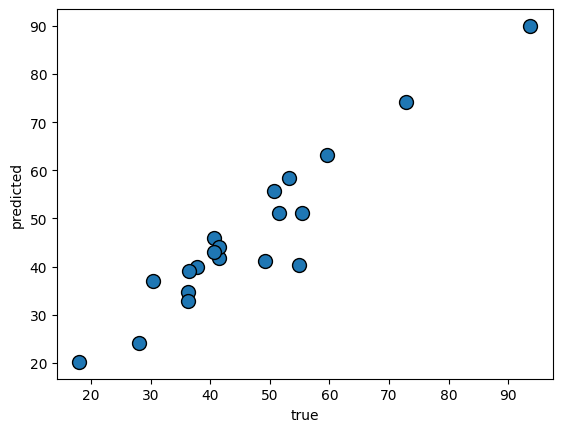

Mean squared error: 25.133323102783805


In [12]:
O=mlp.predict(X_test)
mglearn.discrete_scatter(Y_test,O)
plt.xlabel("true")
plt.ylabel("predicted")
plt.show()
print("Mean squared error: {}".format(mean_squared_error(Y_test,O)))

We investigate the weights of the perceptron:

In [13]:
for i,c in enumerate(mlp.coefs_[0]):
    print("{}: \t{}".format(X.columns.values[i],c[0]))    
    


calories: 	-0.049350904727399426
protein: 	3.865961280742382
fat: 	-3.406746352854944
sodium: 	-0.04275725347794841
fiber: 	3.526138283139807
carbo: 	0.8956189786594336
sugars: 	-1.1123653629724695
potass: 	-0.03471001263844922
vitamins: 	-0.09857218801845466
shelf: 	1.9759724280570385
weight: 	3.0803854607365873
cups: 	7.927570009664915
mfr_A: 	-0.40864923482510884
mfr_G: 	1.0204489106512347
mfr_K: 	1.262801860985266
mfr_N: 	6.10142744924324
mfr_P: 	0.8219651297946304
mfr_Q: 	5.598078054361516
mfr_R: 	-0.7148158481738642
type_C: 	13.034319013131283
type_H: 	0.21989408809980737


The weights can be used to assess the importance of different input features. Features with larger weights, will influence the output more than features with smaller weights. However, this has to be seen in conjunction with the numerical scale of the feature values. Compare e.g. the weights and feature value range of the 'cups' and 'potass' features. 

Weight values are more informative when features are scaled to the same range. This can also improve learning results:

## Feature normalization

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)
X_norm_train=scaler.transform(X_train)
X_norm_test=scaler.transform(X_test)
display(X_norm_train)

array([[-0.36643638,  0.59539247, -0.08242256, ..., -0.34299717,
         0.19069252, -0.19069252],
       [ 1.83218188,  0.59539247, -0.08242256, ..., -0.34299717,
         0.19069252, -0.19069252],
       [ 0.18321819,  0.59539247,  0.85719462, ..., -0.34299717,
         0.19069252, -0.19069252],
       ...,
       [ 0.18321819,  0.59539247,  1.79681179, ..., -0.34299717,
         0.19069252, -0.19069252],
       [ 0.18321819, -1.46141787, -0.08242256, ..., -0.34299717,
         0.19069252, -0.19069252],
       [-2.01540007,  1.62379763, -0.08242256, ..., -0.34299717,
         0.19069252, -0.19069252]])

By the scaling operation we 'loose' the Pandas DataFrame structure. Note that how the scaling is done is determined by the training data only. The same scaling operation then is applied also to the test data.

Now we can learn again with the scaled data:

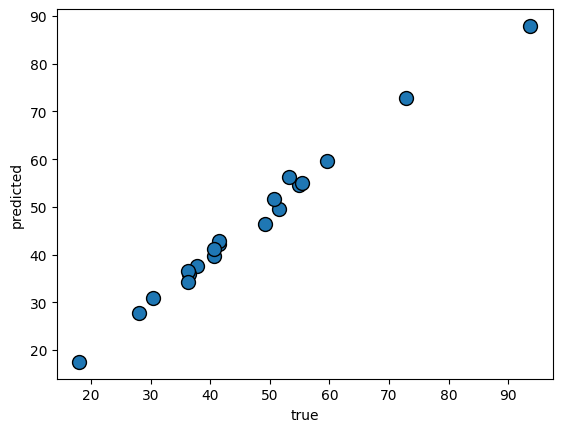

Mean squared error: 3.2451380535391343


In [16]:
mlp = MLPRegressor(hidden_layer_sizes=[],solver='lbfgs',max_iter=200).fit(X_norm_train, Y_train)
O=mlp.predict(X_norm_test)
mglearn.discrete_scatter(Y_test,O)
plt.xlabel("true")
plt.ylabel("predicted")
plt.show()
print("Mean squared error: {}".format(mean_squared_error(Y_test,O)))

With the scaled data, accuracy is better! We can now again look at feature importance:

In [17]:
for i,c in enumerate(mlp.coefs_[0]):
    print("{}: \t{}".format(X.columns.values[i],c[0]))   

calories: 	-2.829341699865944
protein: 	3.157134992920724
fat: 	-2.7196280496391947
sodium: 	-3.735043208442035
fiber: 	4.3840121873801285
carbo: 	1.6099164075118957
sugars: 	-5.223751357119085
potass: 	-0.9471751385057355
vitamins: 	-1.1669799452678125
shelf: 	0.5024996299340826
weight: 	0.5384088201641677
cups: 	0.34281135966862786
mfr_A: 	0.27798120803653736
mfr_G: 	-0.6137306592303229
mfr_K: 	-0.02293360149751821
mfr_N: 	0.7571742588876798
mfr_P: 	-0.09865976292946373
mfr_Q: 	-0.6332744994139365
mfr_R: 	0.10705960565894072
type_C: 	0.4837949227053887
type_H: 	-0.09296334341448849


This makes more sense: fiber is good, sugars are bad, and cups do not matter!

We compare the accuracy of the learned model as a function of the 'max_iter' hyperparameter when learning from the original and the normalized data:

In [18]:
iters=np.arange(100,4000,200)
loss_orig = np.zeros(iters.size)
loss_norm = np.zeros(iters.size)
loss_orig_deep = np.zeros(iters.size)
loss_norm_deep = np.zeros(iters.size)
for i,it in enumerate(iters):
    mlp = MLPRegressor(hidden_layer_sizes=[],solver='lbfgs',max_iter=it).fit(X_train, Y_train)
    O=mlp.predict(X_test)
    loss_orig[i]=mean_squared_error(Y_test,O)
    mlp = MLPRegressor(hidden_layer_sizes=[],solver='lbfgs',max_iter=it).fit(X_norm_train, Y_train)
    O=mlp.predict(X_norm_test)
    loss_norm[i]=mean_squared_error(Y_test,O)
    mlp = MLPRegressor(hidden_layer_sizes=[10,10],solver='lbfgs',max_iter=it).fit(X_train, Y_train)
    O=mlp.predict(X_test)
    loss_orig_deep[i]=mean_squared_error(Y_test,O)
    mlp = MLPRegressor(hidden_layer_sizes=[10,10],solver='lbfgs',max_iter=it).fit(X_norm_train, Y_train)
    O=mlp.predict(X_norm_test)
    loss_norm_deep[i]=mean_squared_error(Y_test,O)

c:\Users\KennethElong(KEEL)\IdeaProjects\firstPythonProject\firstPyhtonProject\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\KennethElong(KEEL)\IdeaProjects\firstPythonProject\firstPyhtonProject\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\KennethElong(KEEL)\IdeaProjects\firstPythonProj

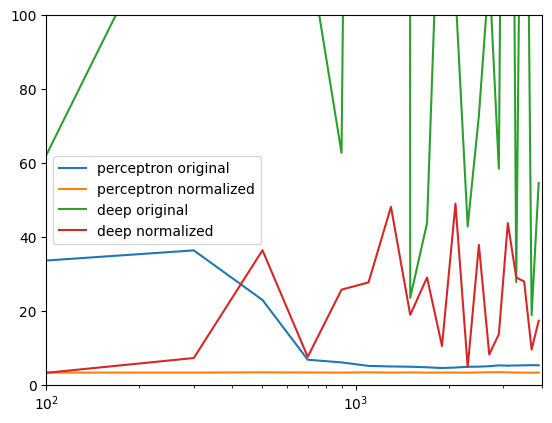

In [19]:
plt.plot(iters,loss_orig,label='perceptron original')
plt.plot(iters,loss_norm,label='perceptron normalized')
plt.plot(iters,loss_orig_deep,label='deep original')
plt.plot(iters,loss_norm_deep,label='deep normalized')
plt.xscale('log')
plt.axis([100, 4000, 0, 100])
plt.legend()
plt.show()

We see that for the perceptron, the normalization mainly helps to find a good model faster. If we allow sufficiently many iterations, then the perceptron will also become accurate on the un-normalized data. For the 'deep' model we observe quite a lot of variability in the results, due to the different degrees of overfitting in different runs. Normalizing helps a little bit to bring this variability down. The main insight we can get here, however, is that the deep model is too complex for this dataset.